<a href="https://colab.research.google.com/github/Ronin1289/Generating-Building-Drawings-Using-Image-Processing/blob/main/Sample_Project_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DEEPLSD

###INSTALLING LIBRARIES

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!git clone --recurse-submodules https://github.com/cvg/DeepLSD.git
%cd DeepLSD
!bash quickstart_install.sh
!pip install omegaconf
!pip install pytlsd
!pip install flow_vis
!pip install pytorch as torch
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

Cloning into 'DeepLSD'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 266 (delta 29), reused 33 (delta 22), pack-reused 217 (from 1)
Receiving objects: 100% (266/266), 7.50 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Submodule 'line_refinement/pybind11' (https://github.com/pybind/pybind11) registered for path 'line_refinement/pybind11'
Submodule 'third_party/homography_est' (https://github.com/rpautrat/homography_est.git) registered for path 'third_party/homography_est'
Submodule 'third_party/progressive-x' (https://github.com/danini/progressive-x.git) registered for path 'third_party/progressive-x'
Submodule 'third_party/pytlbd' (https://github.com/iago-suarez/pytlbd.git) registered for path 'third_party/pytlbd'
Submodule 'third_party/pytlsd' (https://github.com/iago-suarez/pytlsd.git) registered for path 'third_party/pytlsd'
Cloning into '/content/DeepLSD/line

In [ ]:
import torch

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '/content/drive/MyDrive/RESEARCH DATA/deeplsd_md.tar'
# ckpt = torch.load(str(ckpt), map_location='cpu',weights_only='false')
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)

net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()





In [ ]:


def deeplsd(image):
  # Detect (and optionally refine) the lines
  inputs = {'image': torch.tensor(img, dtype=torch.float, device=device)[None, None] / 255.}
  with torch.no_grad():
      out = net(inputs)
      pred_lines = out['lines'][0]
  return pred_lines


##LOADING IMAGE AND DETECTING LINES

In [ ]:
img=cv2.imread("/content/drive/MyDrive/RESEARCH DATA/GSCK/Orthographic_image.png",cv2.IMREAD_GRAYSCALE)

In [ ]:
lines=deeplsd(img)

##REFINING LINES

In [ ]:
import numpy as np

def REFINE(og_lines):
    """
    Complete pipeline to process line segments:
    1. Correct raw lines to strictly horizontal or vertical
    2. Merge horizontal lines
    3. Bridge gaps between horizontal lines
    4. Remove short horizontal lines
    5. Merge vertical lines
    6. Combine final horizontal and vertical lines

    Parameters:
    - og_lines (np.array): Original raw line segments of shape (n, 2, 2)

    Returns:
    - np.array: Final processed lines of shape (m, 2, 2)
    """

    # Step 1: Correct lines to strictly horizontal or vertical
    corrected_lines = []
    for (x1, y1), (x2, y2) in og_lines:
        if x1 == x2:
            corrected_lines.append([(x1, y1), (x2, y2)])
        else:
            slope = abs((y2 - y1) / (x2 - x1)) if (x2 - x1) != 0 else float('inf')
            if slope < 3:
                corrected_lines.append([(x1, y1), (x2, y1)])
            elif slope > 87:
                corrected_lines.append([(x1, y1), (x1, y2)])
    lines = np.array(corrected_lines)

    # Step 2: Merge horizontal lines
    horizontal_lines = [line for line in lines if abs(line[0][1] - line[1][1]) < 1e-3]
    if horizontal_lines:
        horizontal_lines = np.array(horizontal_lines)
        horizontal_lines = horizontal_lines[np.argsort(horizontal_lines[:, 0, 1])]
        merged_horizontal = []
        while len(horizontal_lines) > 0:
            base_x1, base_y1 = horizontal_lines[0][0]
            base_x2, base_y2 = horizontal_lines[0][1]
            close_lines = [horizontal_lines[0]]
            to_remove = [0]
            for i in range(1, len(horizontal_lines)):
                (x1, y1), (x2, y2) = horizontal_lines[i]
                if abs(y1 - base_y1) <= 2 and (abs(x1 - base_x2) <= 50 or abs(base_x1 - x2) <= 50):
                    close_lines.append(horizontal_lines[i])
                    to_remove.append(i)
                    base_x1 = min(base_x1, x1)
                    base_x2 = max(base_x2, x2)
            horizontal_lines = np.delete(horizontal_lines, to_remove, axis=0)
            close_lines = np.array(close_lines)
            min_x = np.min(close_lines[:, 0, 0])
            max_x = np.max(close_lines[:, 1, 0])
            avg_y = np.mean(close_lines[:, 0, 1])
            merged_horizontal.append([[min_x, avg_y], [max_x, avg_y]])
        lh = np.array(merged_horizontal)
    else:
        lh = np.empty((0, 2, 2))

    # Step 3: Bridge gaps in horizontal lines
    if lh.size > 0:
        lh = lh[np.argsort(lh[:, 0, 1])]
        bridged_horizontal = []
        used = np.zeros(len(lh), dtype=bool)
        for i, (p1, p2) in enumerate(lh):
            if used[i]:
                continue
            x1, y1 = p1
            x2, y2 = p2
            for j in range(i + 1, len(lh)):
                if used[j]:
                    continue
                nx1, ny1 = lh[j][0]
                nx2, ny2 = lh[j][1]
                if abs(ny1 - y1) < 7 and 0 < nx1 - x2 <= 70:
                    x2 = nx2
                    used[j] = True
            bridged_horizontal.append([[x1, y1], [x2, y2]])
            used[i] = True
        lh = np.array(bridged_horizontal)

    # Step 4: Remove short horizontal lines
    filtered_horizontal = []
    for p1, p2 in lh:
        x1, y1 = p1
        x2, y2 = p2
        if np.hypot(x2 - x1, y2 - y1) >= 70:
            filtered_horizontal.append([p1, p2])
    lh2 = np.array(filtered_horizontal)

    # Step 5: Merge vertical lines
    vertical_lines = [line for line in lines if abs(line[0][0] - line[1][0]) < 1e-3]
    if vertical_lines:
        vertical_lines = np.array(vertical_lines)
        vertical_lines = vertical_lines[np.argsort(vertical_lines[:, 0, 0])]
        merged_vertical = []
        while len(vertical_lines) > 0:
            base_x1, base_y1 = vertical_lines[0][0]
            base_x2, base_y2 = vertical_lines[0][1]
            close_lines = [vertical_lines[0]]
            to_remove = [0]
            for i in range(1, len(vertical_lines)):
                (x1, y1), (x2, y2) = vertical_lines[i]
                if abs(x1 - base_x1) <= 5 and (abs(y1 - base_y2) <= 10 or abs(base_y1 - y2) <= 10):
                    close_lines.append(vertical_lines[i])
                    to_remove.append(i)
                    base_y1 = min(base_y1, y1)
                    base_y2 = max(base_y2, y2)
            vertical_lines = np.delete(vertical_lines, to_remove, axis=0)
            close_lines = np.array(close_lines)
            min_y = np.min(close_lines[:, 0, 1])
            max_y = np.max(close_lines[:, 1, 1])
            avg_x = np.mean(close_lines[:, 0, 0])
            merged_vertical.append([[avg_x, min_y], [avg_x, max_y]])
        lv = np.array(merged_vertical)
    else:
        lv = np.empty((0, 2, 2))

    # Step 6: Combine horizontal and vertical lines
    if lh2.size == 0:
        return lv
    if lv.size == 0:
        return lh2
    return np.vstack((lh2, lv))


In [ ]:
REFINED_LINES=REFINE(lines)

##DISPLAYING RESULTS


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def displ(lines,title="Detected Lines"):
    """Plots lines from an array of shape (N, 1, 4) or (N, 4)."""
    # Reshape if necessary
    lines = lines.reshape(-1, 4)

    # Plot the lines
    plt.figure(figsize=(10, 5))
    for x1, y1, x2, y2 in lines:
        plt.plot([x1, x2], [y1, y2], 'k-')  # Blue lines

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert Y-axis if needed
    plt.axis("equal")  # Keep aspect ratio
    plt.show()


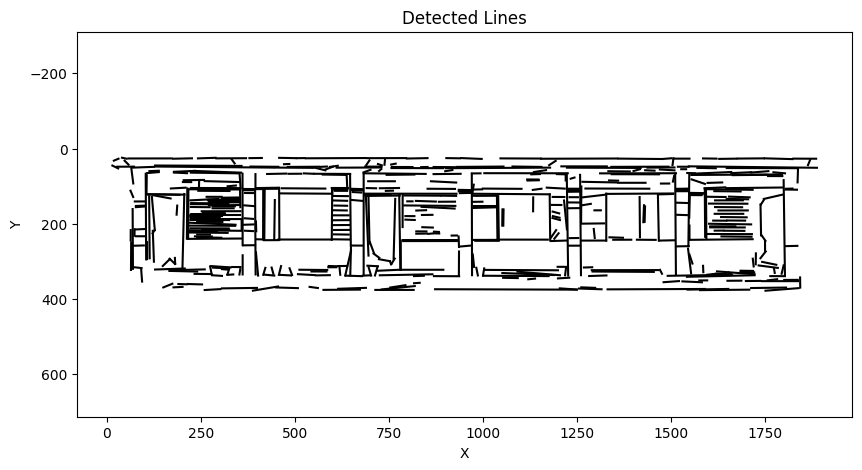

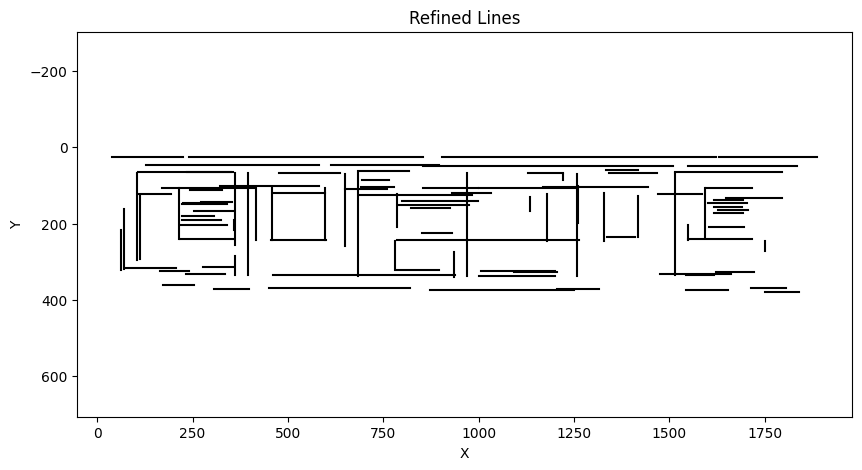

In [ ]:
displ(lines)
displ(REFINED_LINES,"Refined Lines")

##DOWNLOADING OUTPUT

In [ ]:
pip install ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.9 MB/s eta 0:00:00


In [ ]:
import ezdxf
import numpy as np

def save_lines_to_dxf1(lines, filename="output.dxf"):
    """
    Saves a set of 2D line segments to a DXF file.

    Parameters:
    - lines: numpy array of shape (N, 2, 2), where each line is [[x1, y1], [x2, y2]]
    - filename: name of the output DXF file
    """
    # Create a new DXF document
    doc = ezdxf.new()
    msp = doc.modelspace()

    # Automatically detect image height based on maximum Y value
    y_values = lines[:, :, 1]  # extract all y-values
    image_height = np.max(y_values)

    # Add lines with flipped Y coordinates (relative to image height)
    for line in lines:
        (x1, y1), (x2, y2) = line
        y1_flipped = image_height - y1
        y2_flipped = image_height - y2
        msp.add_line(start=(x1, y1_flipped), end=(x2, y2_flipped))

    # Save DXF file
    doc.saveas(filename)
    print(f"DXF file saved as {filename}")

# Example usage
save_lines_to_dxf1(REFINED_LINES, "Approach 4.dxf")
def download_dxf(filename="output.dxf"):
    from google.colab import files
    files.download(filename)

download_dxf("Approach 4.dxf")

DXF file saved as Approach 4.dxf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>